In [274]:
import pandas as pd
import matplotlib.pyplot as plt
import json
from datetime import datetime
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error
import requests
import concurrent.futures
import geopandas as gpd
from shapely.geometry import Point
import numpy as np

# Data aggregation

In [275]:
df_bike_trips = pd.read_parquet('../../data/bike_trips_cleaned.parquet')
df_bike_trips.head()

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,end_station_name,start_station_name,duration,start_lat,start_lon,end_lat,end_lon,distance,speed,average_time,date_time,max_temp,min_temp,precip
index,,,,,,,,,,,,,,,,,,,,
0,2016-01-01 00:04:00,2016-01-01 00:14:00,3046,3041,3564,Indego30,"Girard Station, MFL",2nd & Market,0 days 00:10:00,39.949895,-75.143749,39.969241,-75.136180,1.005648,6.033888,2016-01-01 00:09:00,2016-01-01 00:00:00,6.7,6.7,0.0
1,2016-01-01 00:07:00,2016-01-01 00:29:00,3028,3019,2629,Indego30,6th & Race,4th & Bainbridge,0 days 00:22:00,39.940735,-75.149370,39.954694,-75.149496,0.397798,1.084905,2016-01-01 00:18:00,2016-01-01 00:00:00,6.7,6.7,0.0
2,2016-01-01 00:14:00,2016-01-01 00:27:00,3007,3066,3430,Indego30,19th & Lombard,"11th & Pine, Kahn Park",0 days 00:13:00,39.945123,-75.159952,39.945664,-75.173272,1.480278,6.832050,2016-01-01 00:20:30,2016-01-01 00:00:00,6.7,6.7,0.0
3,2016-01-01 00:20:00,2016-01-01 00:30:00,3045,3028,3715,Indego30,4th & Bainbridge,13th & Locust,0 days 00:10:00,39.947947,-75.162361,39.940735,-75.149370,1.458133,8.748797,2016-01-01 00:25:00,2016-01-01 00:00:00,6.7,6.7,0.0
4,2016-01-01 00:20:00,2016-01-01 00:42:00,3005,3064,3351,Walk-up,"18th & Washington, Chew Playground","Welcome Park, NPS",0 days 00:22:00,39.947383,-75.144145,39.938280,-75.173873,3.313616,9.037136,2016-01-01 00:31:00,2016-01-01 01:00:00,7.2,7.2,0.0


In [276]:
# floor start and end times of trips to hour value, i.e. ignore minutes and seconds
df_bike_trips['start_time_floored'] = df_bike_trips['start_time'].dt.floor('H')
df_bike_trips['end_time_floored'] = df_bike_trips['end_time'].dt.floor('H')

df_bike_trips.head(70)

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,end_station_name,start_station_name,duration,start_lat,...,end_lon,distance,speed,average_time,date_time,max_temp,min_temp,precip,start_time_floored,end_time_floored
index,,,,,,,,,,,,,,,,,,,,,
0,2016-01-01 00:04:00,2016-01-01 00:14:00,3046,3041,3564,Indego30,"Girard Station, MFL",2nd & Market,0 days 00:10:00,39.949895,...,-75.136180,1.005648,6.033888,2016-01-01 00:09:00,2016-01-01 00:00:00,6.7,6.7,0.0,2016-01-01 00:00:00,2016-01-01 00:00:00
1,2016-01-01 00:07:00,2016-01-01 00:29:00,3028,3019,2629,Indego30,6th & Race,4th & Bainbridge,0 days 00:22:00,39.940735,...,-75.149496,0.397798,1.084905,2016-01-01 00:18:00,2016-01-01 00:00:00,6.7,6.7,0.0,2016-01-01 00:00:00,2016-01-01 00:00:00
2,2016-01-01 00:14:00,2016-01-01 00:27:00,3007,3066,3430,Indego30,19th & Lombard,"11th & Pine, Kahn Park",0 days 00:13:00,39.945123,...,-75.173272,1.480278,6.832050,2016-01-01 00:20:30,2016-01-01 00:00:00,6.7,6.7,0.0,2016-01-01 00:00:00,2016-01-01 00:00:00
3,2016-01-01 00:20:00,2016-01-01 00:30:00,3045,3028,3715,Indego30,4th & Bainbridge,13th & Locust,0 days 00:10:00,39.947947,...,-75.149370,1.458133,8.748797,2016-01-01 00:25:00,2016-01-01 00:00:00,6.7,6.7,0.0,2016-01-01 00:00:00,2016-01-01 00:00:00
4,2016-01-01 00:20:00,2016-01-01 00:42:00,3005,3064,3351,Walk-up,"18th & Washington, Chew Playground","Welcome Park, NPS",0 days 00:22:00,39.947383,...,-75.173873,3.313616,9.037136,2016-01-01 00:31:00,2016-01-01 01:00:00,7.2,7.2,0.0,2016-01-01 00:00:00,2016-01-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,2016-01-01 02:02:00,2016-01-01 02:16:00,3041,3041,3560,Walk-up,"Girard Station, MFL","Girard Station, MFL",0 days 00:14:00,39.969241,...,-75.136180,0.000000,0.000000,2016-01-01 02:09:00,2016-01-01 02:00:00,6.7,6.7,0.0,2016-01-01 02:00:00,2016-01-01 02:00:00
66,2016-01-01 01:58:00,2016-01-01 02:21:00,3052,3070,3555,Walk-up,"Spring Garden Station, MFL",9th & Locust,0 days 00:23:00,39.947164,...,-75.140359,1.788087,4.664576,2016-01-01 02:09:30,2016-01-01 02:00:00,6.7,6.7,0.0,2016-01-01 01:00:00,2016-01-01 02:00:00
67,2016-01-01 01:59:00,2016-01-01 02:21:00,3052,3070,3440,Walk-up,"Spring Garden Station, MFL",9th & Locust,0 days 00:22:00,39.947164,...,-75.140359,1.788087,4.876602,2016-01-01 02:10:00,2016-01-01 02:00:00,6.7,6.7,0.0,2016-01-01 01:00:00,2016-01-01 02:00:00


In [277]:
# calculate the number of starting and ending trips for each hour
starting_trips_grouped = (
    df_bike_trips.groupby(["start_time_floored"])
    .size()
    .to_frame("starting_trips")
)
ending_trips_grouped = (
    df_bike_trips.groupby(["end_time_floored"])
    .size()
    .to_frame("ending_trips")
)

df_bike_trips.head()

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,end_station_name,start_station_name,duration,start_lat,...,end_lon,distance,speed,average_time,date_time,max_temp,min_temp,precip,start_time_floored,end_time_floored
index,,,,,,,,,,,,,,,,,,,,,
0,2016-01-01 00:04:00,2016-01-01 00:14:00,3046,3041,3564,Indego30,"Girard Station, MFL",2nd & Market,0 days 00:10:00,39.949895,...,-75.136180,1.005648,6.033888,2016-01-01 00:09:00,2016-01-01 00:00:00,6.7,6.7,0.0,2016-01-01,2016-01-01
1,2016-01-01 00:07:00,2016-01-01 00:29:00,3028,3019,2629,Indego30,6th & Race,4th & Bainbridge,0 days 00:22:00,39.940735,...,-75.149496,0.397798,1.084905,2016-01-01 00:18:00,2016-01-01 00:00:00,6.7,6.7,0.0,2016-01-01,2016-01-01
2,2016-01-01 00:14:00,2016-01-01 00:27:00,3007,3066,3430,Indego30,19th & Lombard,"11th & Pine, Kahn Park",0 days 00:13:00,39.945123,...,-75.173272,1.480278,6.832050,2016-01-01 00:20:30,2016-01-01 00:00:00,6.7,6.7,0.0,2016-01-01,2016-01-01
3,2016-01-01 00:20:00,2016-01-01 00:30:00,3045,3028,3715,Indego30,4th & Bainbridge,13th & Locust,0 days 00:10:00,39.947947,...,-75.149370,1.458133,8.748797,2016-01-01 00:25:00,2016-01-01 00:00:00,6.7,6.7,0.0,2016-01-01,2016-01-01
4,2016-01-01 00:20:00,2016-01-01 00:42:00,3005,3064,3351,Walk-up,"18th & Washington, Chew Playground","Welcome Park, NPS",0 days 00:22:00,39.947383,...,-75.173873,3.313616,9.037136,2016-01-01 00:31:00,2016-01-01 01:00:00,7.2,7.2,0.0,2016-01-01,2016-01-01


In [278]:
# combine these values into a single dataframe and determine whether data cleaning is necessary
df_bike_trips_hourly = pd.concat([starting_trips_grouped, ending_trips_grouped], axis=1)
df_bike_trips_hourly.isna().sum()
#df_bike_trips_hourly.tail()

starting_trips    54
ending_trips      43
dtype: int64

In [279]:
df_bike_trips_hourly = df_bike_trips_hourly.fillna(0) 
df_bike_trips_hourly.isna().sum()
#df_bike_trips_hourly.tail()

starting_trips    0
ending_trips      0
dtype: int64

In [280]:
df_bike_trips_hourly.to_parquet('../../data/bike_trips_hourly.parquet')

In [281]:
df_bike_trips_hourly.head()

,starting_trips,ending_trips
2016-01-01 00:00:00,26.0,17.0
2016-01-01 01:00:00,39.0,32.0
2016-01-01 02:00:00,33.0,37.0
2016-01-01 03:00:00,6.0,10.0
2016-01-01 04:00:00,1.0,1.0


In [282]:
print(len(df_bike_trips_hourly))

8588


# Feature engineering

In [283]:
# von github? find source
neighborhoods= gpd.read_file('../../data/Neighborhoods_Philadelphia.geojson')


In [284]:
# add columns for geojson 
df_bike_trips['start_geometry'] = df_bike_trips.apply(lambda row: Point(np.array([row['start_lon'], row['start_lat']])), axis=1)
# df_bike_trips['end_geometry'] = df_bike_trips.apply(lambda row: Point(np.array([row['end_lon'], row['end_lat']])), axis=1)

C:\Users\novem\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [285]:
print(len(df_bike_trips_hourly))

8588


In [286]:
# adjust crs of df_bike_trips to prepare for merge
gdf = gpd.GeoDataFrame(df_bike_trips, geometry='start_geometry')
gdf.crs = 'epsg:4326'
print(neighborhoods.crs)
print(gdf.crs)

epsg:4326
epsg:4326


In [287]:
merged = gpd.sjoin(gdf, neighborhoods, op='within')

In [288]:
merged.tail()

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,end_station_name,start_station_name,duration,start_lat,...,start_geometry,index_right,name,listname,mapname,shape_leng,shape_area,cartodb_id,created_at,updated_at
index,,,,,,,,,,,,,,,,,,,,,
644034,2016-12-28 09:42:00,2016-12-28 10:07:00,3117,3119,2633,Indego30,42nd & Lancaster,ParkWest Town Center,0 days 00:25:00,39.978087,...,POINT (-75.22353 39.97809),126,WEST_PARKSIDE,West Parkside,West Parkside,11392.249332,7.502885e+06,132,2013-03-19T17:41:50,2013-03-19T17:41:50
644861,2016-12-29 05:04:00,2016-12-29 05:24:00,3117,3020,2502,Indego30,University City Station,ParkWest Town Center,0 days 00:20:00,39.978087,...,POINT (-75.22353 39.97809),126,WEST_PARKSIDE,West Parkside,West Parkside,11392.249332,7.502885e+06,132,2013-03-19T17:41:50,2013-03-19T17:41:50
645108,2016-12-29 15:29:00,2016-12-29 16:04:00,3117,3056,3279,Indego30,Broad & Oxford,ParkWest Town Center,0 days 00:35:00,39.978087,...,POINT (-75.22353 39.97809),126,WEST_PARKSIDE,West Parkside,West Parkside,11392.249332,7.502885e+06,132,2013-03-19T17:41:50,2013-03-19T17:41:50
646038,2016-12-30 15:24:00,2016-12-30 15:34:00,3117,3111,2611,Indego30,"Parkside & Belmont, Case Building",ParkWest Town Center,0 days 00:10:00,39.978087,...,POINT (-75.22353 39.97809),126,WEST_PARKSIDE,West Parkside,West Parkside,11392.249332,7.502885e+06,132,2013-03-19T17:41:50,2013-03-19T17:41:50
646374,2016-12-30 22:44:00,2016-12-30 23:08:00,3117,3078,11004,Indego30,19th & Market,ParkWest Town Center,0 days 00:24:00,39.978087,...,POINT (-75.22353 39.97809),126,WEST_PARKSIDE,West Parkside,West Parkside,11392.249332,7.502885e+06,132,2013-03-19T17:41:50,2013-03-19T17:41:50


In [289]:
print(len(merged))

647057


In [290]:
print(len(df_bike_trips_hourly))

8588


In [291]:
most_common_listname = merged.groupby(df_bike_trips['start_time'].dt.floor('H'))['listname'].agg(lambda x:x.value_counts().index[0])
# most_common_listname = merged.groupby(df_bike_trips['start_time'].dt.floor('H'))['name'].agg(lambda x:x.value_counts().index[0])

In [302]:
merged.iloc[300:350]

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,end_station_name,start_station_name,duration,start_lat,...,start_geometry,index_right,name,listname,mapname,shape_leng,shape_area,cartodb_id,created_at,updated_at
index,,,,,,,,,,,,,,,,,,,,,
4284,2016-01-07 17:10:00,2016-01-07 17:26:00,3005,3005,3426,Indego30,"Welcome Park, NPS","Welcome Park, NPS",0 days 00:16:00,39.947383,...,POINT (-75.14415 39.94738),109,OLD_CITY,Old City,Old City,14323.371697,1.255444e+07,92,2013-03-19T17:41:50,2013-03-19T17:41:50
4288,2016-01-07 17:15:00,2016-01-07 17:23:00,3019,3007,3301,Indego30,"11th & Pine, Kahn Park",6th & Race,0 days 00:08:00,39.954694,...,POINT (-75.14950 39.95469),109,OLD_CITY,Old City,Old City,14323.371697,1.255444e+07,92,2013-03-19T17:41:50,2013-03-19T17:41:50
4304,2016-01-07 17:18:00,2016-01-07 17:35:00,3005,3069,2481,Indego30,4th & Christian,"Welcome Park, NPS",0 days 00:17:00,39.947383,...,POINT (-75.14415 39.94738),109,OLD_CITY,Old City,Old City,14323.371697,1.255444e+07,92,2013-03-19T17:41:50,2013-03-19T17:41:50
4315,2016-01-07 17:25:00,2016-01-07 17:43:00,3019,3051,3622,Indego30,23rd & Fairmount,6th & Race,0 days 00:18:00,39.954694,...,POINT (-75.14950 39.95469),109,OLD_CITY,Old City,Old City,14323.371697,1.255444e+07,92,2013-03-19T17:41:50,2013-03-19T17:41:50
4319,2016-01-07 17:28:00,2016-01-07 17:48:00,3015,3058,3694,Indego30,20th & Fairmount,"4th & Walnut, NPS",0 days 00:20:00,39.947319,...,POINT (-75.14792 39.94732),109,OLD_CITY,Old City,Old City,14323.371697,1.255444e+07,92,2013-03-19T17:41:50,2013-03-19T17:41:50
4326,2016-01-07 17:35:00,2016-01-07 17:48:00,3047,3014,3375,Indego30,"21st & Winter, Franklin Institute","Independence Mall, NPS",0 days 00:13:00,39.949531,...,POINT (-75.14973 39.94953),109,OLD_CITY,Old City,Old City,14323.371697,1.255444e+07,92,2013-03-19T17:41:50,2013-03-19T17:41:50
4327,2016-01-07 17:38:00,2016-01-07 17:45:00,3050,3045,3678,Indego30,13th & Locust,9th & Arch,0 days 00:07:00,39.953352,...,POINT (-75.15471 39.95335),109,OLD_CITY,Old City,Old City,14323.371697,1.255444e+07,92,2013-03-19T17:41:50,2013-03-19T17:41:50
4339,2016-01-07 17:42:00,2016-01-07 17:59:00,3015,3054,2534,Indego30,Rodin Museum,"4th & Walnut, NPS",0 days 00:17:00,39.947319,...,POINT (-75.14792 39.94732),109,OLD_CITY,Old City,Old City,14323.371697,1.255444e+07,92,2013-03-19T17:41:50,2013-03-19T17:41:50
4341,2016-01-07 17:49:00,2016-01-07 17:53:00,3005,3026,3426,Indego30,2nd & South,"Welcome Park, NPS",0 days 00:04:00,39.947383,...,POINT (-75.14415 39.94738),109,OLD_CITY,Old City,Old City,14323.371697,1.255444e+07,92,2013-03-19T17:41:50,2013-03-19T17:41:50


In [292]:
print(len(most_common_listname))

8534


In [293]:
df_bike_trips_hourly = df_bike_trips_hourly.merge(most_common_listname, left_index=True, right_index=True, how='outer', indicator=True)

# df_bike_trips_hourly = df_bike_trips_hourly.rename(columns={'listname': 'Most_Occuring_Starting_Neighborhood'})

Missing values in df1:
                     starting_trips  ending_trips listname     _merge
2016-01-06 01:00:00             0.0           1.0      NaN  left_only
2016-01-06 03:00:00             0.0           2.0      NaN  left_only
2016-01-07 03:00:00             0.0           1.0      NaN  left_only
2016-01-08 02:00:00             0.0           3.0      NaN  left_only
2016-01-13 01:00:00             0.0           2.0      NaN  left_only
2016-01-15 02:00:00             0.0           2.0      NaN  left_only
2016-01-15 04:00:00             0.0           1.0      NaN  left_only
2016-01-16 04:00:00             0.0           1.0      NaN  left_only
2016-01-22 02:00:00             0.0           4.0      NaN  left_only
2016-01-23 00:00:00             0.0           1.0      NaN  left_only
2016-01-25 20:00:00             0.0           1.0      NaN  left_only
2016-01-27 06:00:00             0.0           1.0      NaN  left_only
2016-01-31 05:00:00             0.0           1.0      NaN  left_on

In [304]:
df_bike_trips_hourly.iloc[100:150]



,starting_trips,ending_trips,listname,_merge
2016-01-05 10:00:00,23.0,25.0,Queen Village,both
2016-01-05 11:00:00,15.0,15.0,Rittenhouse,both
2016-01-05 12:00:00,23.0,22.0,Rittenhouse,both
2016-01-05 13:00:00,26.0,26.0,Washington Square West,both
2016-01-05 14:00:00,36.0,33.0,Washington Square West,both
2016-01-05 15:00:00,30.0,30.0,Logan Square,both
2016-01-05 16:00:00,50.0,41.0,University City,both
2016-01-05 17:00:00,85.0,90.0,University City,both
2016-01-05 18:00:00,60.0,59.0,University City,both
2016-01-05 19:00:00,46.0,52.0,University City,both


In [273]:
print(len(df_bike_trips_hourly))

NameError: name 'key' is not defined

In [226]:
df_bike_trips_hourly.head()

,starting_trips,ending_trips,Most_Occuring_Starting_Neighborhood
2016-01-01 00:00:00,26.0,17.0,Old City
2016-01-01 01:00:00,39.0,32.0,Washington Square West
2016-01-01 02:00:00,33.0,37.0,"Kensington, Old"
2016-01-01 03:00:00,6.0,10.0,Rittenhouse
2016-01-01 04:00:00,1.0,1.0,"Kensington, West"


In [227]:
missingvalue123 = (df_bike_trips_hourly["Most_Occuring_Starting_Neighborhood"] == "").idxmax()


In [229]:
troll2= df_bike_trips_hourly.where(df_bike_trips_hourly.Most_Occuring_Starting_Neighborhood == "").Most_Occuring_Starting_Neighborhood.first_valid_index()

In [230]:
print(f" starts at index {troll1}")
print(f" starts at index {troll2}")

Missing start neighborhood data starts at index 2016-01-01 00:00:00
Missing end neighborhood data starts at index None


In [231]:
df_bike_trips_hourly.to_csv('../../data/troll.csv')

In [175]:
print(len(df_bike_trips_hourly))

8534


In [178]:
# df_bike_trips_hourly.isna().sum()


,starting_trips,ending_trips,Most Occuring Starting Neighborhood,Most Occuring Starting Neighborhood
2016-12-31 19:00:00,28.0,20.0,Logan Square,Logan Square
2016-12-31 20:00:00,29.0,29.0,Rittenhouse,Rittenhouse
2016-12-31 21:00:00,18.0,25.0,Rittenhouse,Rittenhouse
2016-12-31 22:00:00,21.0,19.0,Rittenhouse,Rittenhouse
2016-12-31 23:00:00,12.0,15.0,Washington Square West,Washington Square West


In [177]:
print(len(df_bike_trips_hourly))

8534


### Add weather features

In [232]:
df_weather = pd.read_parquet('../../data/weather_hourly_philadelphia_cleaned.parquet')
#df_weather.head()
print(len(df_weather))

8312


In [233]:
df_bike_trips_hourly['max_temp'] = df_weather['max_temp']
df_bike_trips_hourly['min_temp'] = df_weather['min_temp']
df_bike_trips_hourly['precip'] = df_weather['precip']
df_bike_trips_hourly.isna().sum()
print(len(df_bike_trips_hourly))
#df_bike_trips_hourly.head()

8534


In [234]:
#drop null values
df_bike_trips_hourly = df_bike_trips_hourly.dropna()
print(len(df_bike_trips_hourly))

8074


In [129]:
df_bike_trips_hourly.head()

,starting_trips,ending_trips,Most Occuring Starting Neighborhood,max_temp,min_temp,precip
2016-01-01 00:00:00,26.0,17.0,Old City,6.7,6.7,0.0
2016-01-01 01:00:00,39.0,32.0,Washington Square West,7.2,7.2,0.0
2016-01-01 02:00:00,33.0,37.0,"Kensington, Old",6.7,6.7,0.0
2016-01-01 03:00:00,6.0,10.0,Rittenhouse,6.7,6.7,0.0
2016-01-01 04:00:00,1.0,1.0,"Kensington, West",6.1,6.1,0.0


### Time related features

In [130]:
def get_season(dates):
    seasons = []
    for date in dates:
        # Extract the month and day from the datetime object
        month = date.month
        day = date.day

        # Define the start and end dates for each season
        spring_start = '03-20'
        spring_end = '06-20'
        summer_start = '06-21'
        summer_end = '09-22'
        fall_start = '09-23'
        fall_end = '12-20'

        # Check which season the input date belongs to
        if (month == 3 and day >= 20) or (month > 3 and month < 6) or (month == 6 and day <= 20):
            seasons.append('1') # Spring
        elif (month == 6 and day >= 21) or (month > 6 and month < 9) or (month == 9 and day <= 22):
            seasons.append('2') # Summer
        elif (month == 9 and day >= 23) or (month > 9 and month < 12) or (month == 12 and day <= 20):
            seasons.append('3') # Fall
        else:
            seasons.append('4') # Winter
    return seasons

In [131]:
#
df_bike_trips_hourly['hour'] = df_bike_trips_hourly.index.hour
df_bike_trips_hourly['day_of_week'] = df_bike_trips_hourly.index.day_of_week
df_bike_trips_hourly['month'] = df_bike_trips_hourly.index.month
df_bike_trips_hourly['day_of_year'] = df_bike_trips_hourly.index.day_of_year
df_bike_trips_hourly['week'] = df_bike_trips_hourly.index.isocalendar().week.astype('int64')
df_bike_trips_hourly['is_weekday'] = df_bike_trips_hourly['day_of_week'] < 5
#is_weekday as binary variable
df_bike_trips_hourly['is_weekday'] = df_bike_trips_hourly['is_weekday'].astype(int)
df_bike_trips_hourly['date'] = df_bike_trips_hourly.index.date.astype('datetime64[ns]')


df_bike_trips_hourly['season'] = get_season(df_bike_trips_hourly['date'])
df_bike_trips_hourly['season'] = df_bike_trips_hourly['season'].astype(int)
df_bike_trips_hourly.head()


,starting_trips,ending_trips,Most Occuring Starting Neighborhood,max_temp,min_temp,precip,hour,day_of_week,month,day_of_year,week,is_weekday,date,season
2016-01-01 00:00:00,26.0,17.0,Old City,6.7,6.7,0.0,0,4,1,1,53,1,2016-01-01,4
2016-01-01 01:00:00,39.0,32.0,Washington Square West,7.2,7.2,0.0,1,4,1,1,53,1,2016-01-01,4
2016-01-01 02:00:00,33.0,37.0,"Kensington, Old",6.7,6.7,0.0,2,4,1,1,53,1,2016-01-01,4
2016-01-01 03:00:00,6.0,10.0,Rittenhouse,6.7,6.7,0.0,3,4,1,1,53,1,2016-01-01,4
2016-01-01 04:00:00,1.0,1.0,"Kensington, West",6.1,6.1,0.0,4,4,1,1,53,1,2016-01-01,4


In [132]:
df_bike_trips_hourly.iloc[1600:1650,:]

,starting_trips,ending_trips,Most Occuring Starting Neighborhood,max_temp,min_temp,precip,hour,day_of_week,month,day_of_year,week,is_weekday,date,season
2016-03-19 15:00:00,48.0,47.0,Logan Square,6.10,6.10,0.0,15,5,3,79,11,0,2016-03-19,4
2016-03-19 16:00:00,54.0,58.0,Washington Square West,6.70,6.70,0.0,16,5,3,79,11,0,2016-03-19,4
2016-03-19 17:00:00,52.0,46.0,Old City,7.20,7.20,0.0,17,5,3,79,11,0,2016-03-19,4
2016-03-19 18:00:00,37.0,45.0,Rittenhouse,7.20,7.20,0.0,18,5,3,79,11,0,2016-03-19,4
2016-03-19 19:00:00,30.0,28.0,University City,6.70,6.70,0.0,19,5,3,79,11,0,2016-03-19,4
2016-03-19 20:00:00,38.0,47.0,Washington Square West,6.10,6.10,0.0,20,5,3,79,11,0,2016-03-19,4
2016-03-19 21:00:00,27.0,23.0,Washington Square West,4.40,3.90,1.0,21,5,3,79,11,0,2016-03-19,4
2016-03-19 22:00:00,27.0,29.0,Logan Square,3.90,3.90,0.0,22,5,3,79,11,0,2016-03-19,4
2016-03-19 23:00:00,12.0,20.0,Rittenhouse,3.90,3.90,0.0,23,5,3,79,11,0,2016-03-19,4
2016-03-20 00:00:00,15.0,17.0,Rittenhouse,4.40,4.40,0.0,0,6,3,80,11,0,2016-03-20,1


In [133]:
df_bike_trips_hourly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8074 entries, 2016-01-01 00:00:00 to 2016-12-31 23:00:00
Data columns (total 14 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   starting_trips                       8074 non-null   float64       
 1   ending_trips                         8074 non-null   float64       
 2   Most Occuring Starting Neighborhood  8074 non-null   object        
 3   max_temp                             8074 non-null   float64       
 4   min_temp                             8074 non-null   float64       
 5   precip                               8074 non-null   float64       
 6   hour                                 8074 non-null   int64         
 7   day_of_week                          8074 non-null   int64         
 8   month                                8074 non-null   int64         
 9   day_of_year                          8074 non-nul

## Holiday feature ## 

Holidays.json created by ChatGPT by openAI. ggf. Erweiterung für dynamische Feiertage nötig falls wir mehrere Jahre angucken wollen. ChatGPT nutzt nur Daten bis 2021, daher fehlt Juneteenth (neuer Feiertag in USA, in 2021 eingeführt), aber ist für uns soweit irrelevant, da wir eh nur Daten des Jahres 2016 nutzen.

In [134]:
holidays_file = open("../../data/holidays.json")
holidays_json = json.loads(holidays_file.read())

In [135]:
# Convert the dates to datetime objects
# holidays = {k: pd.to_datetime(v) for k, v in holidays.items()}

# Create a dataframe from the dictionary
holidays_df = pd.DataFrame.from_dict(holidays_json, orient='index', columns=['date']).reset_index()
holidays_df = holidays_df.rename(columns={'date': 'holiday_name'})
holidays_df = holidays_df.rename(columns={'index': 'date'})
holidays_df['date'] = pd.to_datetime(holidays_df['date'])

holidays_df.head()





,date,holiday_name
0,2016-01-01,New Year's Day
1,2016-01-18,Martin Luther King Jr. Day
2,2016-02-15,Presidents' Day
3,2016-05-30,Memorial Day
4,2016-07-04,Independence Day


In [136]:
# df_bike_trips_hourly = df_bike_trips_hourly.merge(holidays_df, on='date', how='left')
df_bike_trips_hourly = df_bike_trips_hourly.reset_index().merge(holidays_df, on='date', how='left').set_index('index')
df_bike_trips_hourly.head(5)

,starting_trips,ending_trips,Most Occuring Starting Neighborhood,max_temp,min_temp,precip,hour,day_of_week,month,day_of_year,week,is_weekday,date,season,holiday_name
index,,,,,,,,,,,,,,,
2016-01-01 00:00:00,26.0,17.0,Old City,6.7,6.7,0.0,0,4,1,1,53,1,2016-01-01,4,New Year's Day
2016-01-01 01:00:00,39.0,32.0,Washington Square West,7.2,7.2,0.0,1,4,1,1,53,1,2016-01-01,4,New Year's Day
2016-01-01 02:00:00,33.0,37.0,"Kensington, Old",6.7,6.7,0.0,2,4,1,1,53,1,2016-01-01,4,New Year's Day
2016-01-01 03:00:00,6.0,10.0,Rittenhouse,6.7,6.7,0.0,3,4,1,1,53,1,2016-01-01,4,New Year's Day
2016-01-01 04:00:00,1.0,1.0,"Kensington, West",6.1,6.1,0.0,4,4,1,1,53,1,2016-01-01,4,New Year's Day


In [137]:

df_bike_trips_hourly['is_holiday'] = df_bike_trips_hourly['holiday_name'].notna()
df_bike_trips_hourly = df_bike_trips_hourly.drop(columns=['holiday_name'])
df_bike_trips_hourly['is_holiday'] = df_bike_trips_hourly['is_holiday'].astype(int)
df_bike_trips_hourly.columns

Index(['starting_trips', 'ending_trips', 'Most Occuring Starting Neighborhood',
       'max_temp', 'min_temp', 'precip', 'hour', 'day_of_week', 'month',
       'day_of_year', 'week', 'is_weekday', 'date', 'season', 'is_holiday'],
      dtype='object')

In [138]:
df_bike_trips_hourly.head(25)

,starting_trips,ending_trips,Most Occuring Starting Neighborhood,max_temp,min_temp,precip,hour,day_of_week,month,day_of_year,week,is_weekday,date,season,is_holiday
index,,,,,,,,,,,,,,,
2016-01-01 00:00:00,26.0,17.0,Old City,6.7,6.7,0.0,0,4,1,1,53,1,2016-01-01,4,1
2016-01-01 01:00:00,39.0,32.0,Washington Square West,7.2,7.2,0.0,1,4,1,1,53,1,2016-01-01,4,1
2016-01-01 02:00:00,33.0,37.0,"Kensington, Old",6.7,6.7,0.0,2,4,1,1,53,1,2016-01-01,4,1
2016-01-01 03:00:00,6.0,10.0,Rittenhouse,6.7,6.7,0.0,3,4,1,1,53,1,2016-01-01,4,1
2016-01-01 04:00:00,1.0,1.0,"Kensington, West",6.1,6.1,0.0,4,4,1,1,53,1,2016-01-01,4,1
2016-01-01 05:00:00,4.0,3.0,University City,6.1,6.1,0.0,5,4,1,1,53,1,2016-01-01,4,1
2016-01-01 06:00:00,2.0,1.0,Washington Square West,5.6,5.6,0.0,6,4,1,1,53,1,2016-01-01,4,1
2016-01-01 07:00:00,11.0,12.0,Spring Garden,5.0,5.0,0.0,7,4,1,1,53,1,2016-01-01,4,1
2016-01-01 08:00:00,11.0,8.0,Rittenhouse,5.0,5.0,0.0,8,4,1,1,53,1,2016-01-01,4,1


In [139]:
df_bike_trips_hourly.to_parquet('../../data/bike_trips_hourly.parquet')

# Correlation

In [140]:
df_bike_trips_hourly.corr()

,starting_trips,ending_trips,max_temp,min_temp,precip,hour,day_of_week,month,day_of_year,week,is_weekday,season,is_holiday
starting_trips,1.000000,0.986743,0.365686,0.366256,-0.110077,0.334570,-0.088580,0.221303,0.217726,0.197958,0.114000,-0.196642,-0.042882
ending_trips,0.986743,1.000000,0.381936,0.382587,-0.114504,0.361369,-0.088235,0.223238,0.219663,0.199702,0.113025,-0.198229,-0.043245
max_temp,0.365686,0.381936,1.000000,0.999684,-0.069647,0.143713,-0.006980,0.206760,0.208313,0.175140,0.017125,-0.540439,-0.072896
min_temp,0.366256,0.382587,0.999684,1.000000,-0.076664,0.142473,-0.007153,0.206949,0.208516,0.175508,0.017347,-0.540700,-0.072660
precip,-0.110077,-0.114504,-0.069647,-0.076664,1.000000,0.018201,-0.007436,-0.048209,-0.049158,-0.057478,-0.001919,0.013779,0.006388
hour,0.334570,0.361369,0.143713,0.142473,0.018201,1.000000,-0.004620,-0.021227,-0.021144,-0.020960,0.003393,0.013454,0.000217
day_of_week,-0.088580,-0.088235,-0.006980,-0.007153,-0.007436,-0.004620,1.000000,-0.009395,-0.009308,0.002019,-0.787324,0.019933,-0.111047
month,0.221303,0.223238,0.206760,0.206949,-0.048209,-0.021227,-0.009395,1.000000,0.996499,0.946450,0.005476,-0.011798,0.017415
day_of_year,0.217726,0.219663,0.208313,0.208516,-0.049158,-0.021144,-0.009308,0.996499,1.000000,0.946291,0.005055,-0.012329,0.014740
week,0.197958,0.199702,0.175140,0.175508,-0.057478,-0.020960,0.002019,0.946450,0.946291,1.000000,-0.005179,0.030361,0.075464


<AxesSubplot:>

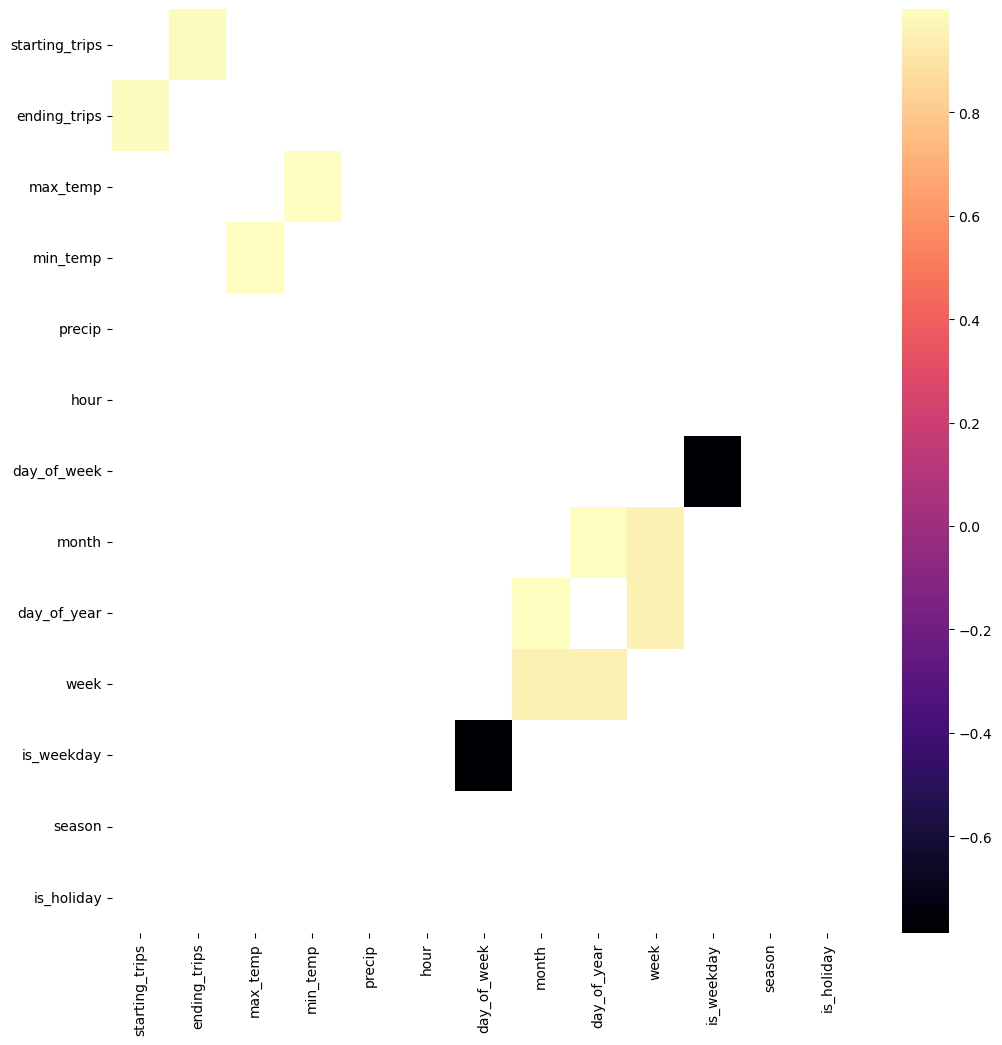

In [141]:
corr = df_bike_trips_hourly.corr()

#kot = corr[((corr>=.7) or (corr<=-.7))]
kot = corr[((corr >= .7) | (corr <= -.7)) & (corr !=1.000)]
plt.figure(figsize=(12,12))
sns.heatmap(kot, cmap="magma")

In [142]:
def corrFilter(x: pd.DataFrame, bound: float):
    xCorr = x.corr()
    xFiltered = xCorr[((xCorr >= bound) | (xCorr <= -bound)) & (xCorr !=1.000)]
    xFlattened = xFiltered.unstack().sort_values().drop_duplicates()
    return xFlattened

corrFilter(df_bike_trips_hourly, .7)

day_of_week     is_weekday       -0.787324
day_of_year     week              0.946291
month           week              0.946450
starting_trips  ending_trips      0.986743
month           day_of_year       0.996499
max_temp        min_temp          0.999684
starting_trips  starting_trips         NaN
dtype: float64

### Correlation with only numeric values in df - use this version as numeric_only will be deprecated

In [143]:
#drop all the columns that are not numeric columns (The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.)
columns_to_drop_corr = ['date']
df_bike_trips_corr = df_bike_trips_hourly.copy()
#df_bike_trips_corr.head()
#df_bike_trips_hourly.head()
df_bike_trips_corr.drop(columns_to_drop_corr, axis=1, inplace=True)

In [144]:
df_bike_trips_corr.corr()

,starting_trips,ending_trips,max_temp,min_temp,precip,hour,day_of_week,month,day_of_year,week,is_weekday,season,is_holiday
starting_trips,1.000000,0.986743,0.365686,0.366256,-0.110077,0.334570,-0.088580,0.221303,0.217726,0.197958,0.114000,-0.196642,-0.042882
ending_trips,0.986743,1.000000,0.381936,0.382587,-0.114504,0.361369,-0.088235,0.223238,0.219663,0.199702,0.113025,-0.198229,-0.043245
max_temp,0.365686,0.381936,1.000000,0.999684,-0.069647,0.143713,-0.006980,0.206760,0.208313,0.175140,0.017125,-0.540439,-0.072896
min_temp,0.366256,0.382587,0.999684,1.000000,-0.076664,0.142473,-0.007153,0.206949,0.208516,0.175508,0.017347,-0.540700,-0.072660
precip,-0.110077,-0.114504,-0.069647,-0.076664,1.000000,0.018201,-0.007436,-0.048209,-0.049158,-0.057478,-0.001919,0.013779,0.006388
hour,0.334570,0.361369,0.143713,0.142473,0.018201,1.000000,-0.004620,-0.021227,-0.021144,-0.020960,0.003393,0.013454,0.000217
day_of_week,-0.088580,-0.088235,-0.006980,-0.007153,-0.007436,-0.004620,1.000000,-0.009395,-0.009308,0.002019,-0.787324,0.019933,-0.111047
month,0.221303,0.223238,0.206760,0.206949,-0.048209,-0.021227,-0.009395,1.000000,0.996499,0.946450,0.005476,-0.011798,0.017415
day_of_year,0.217726,0.219663,0.208313,0.208516,-0.049158,-0.021144,-0.009308,0.996499,1.000000,0.946291,0.005055,-0.012329,0.014740
week,0.197958,0.199702,0.175140,0.175508,-0.057478,-0.020960,0.002019,0.946450,0.946291,1.000000,-0.005179,0.030361,0.075464


<AxesSubplot:>

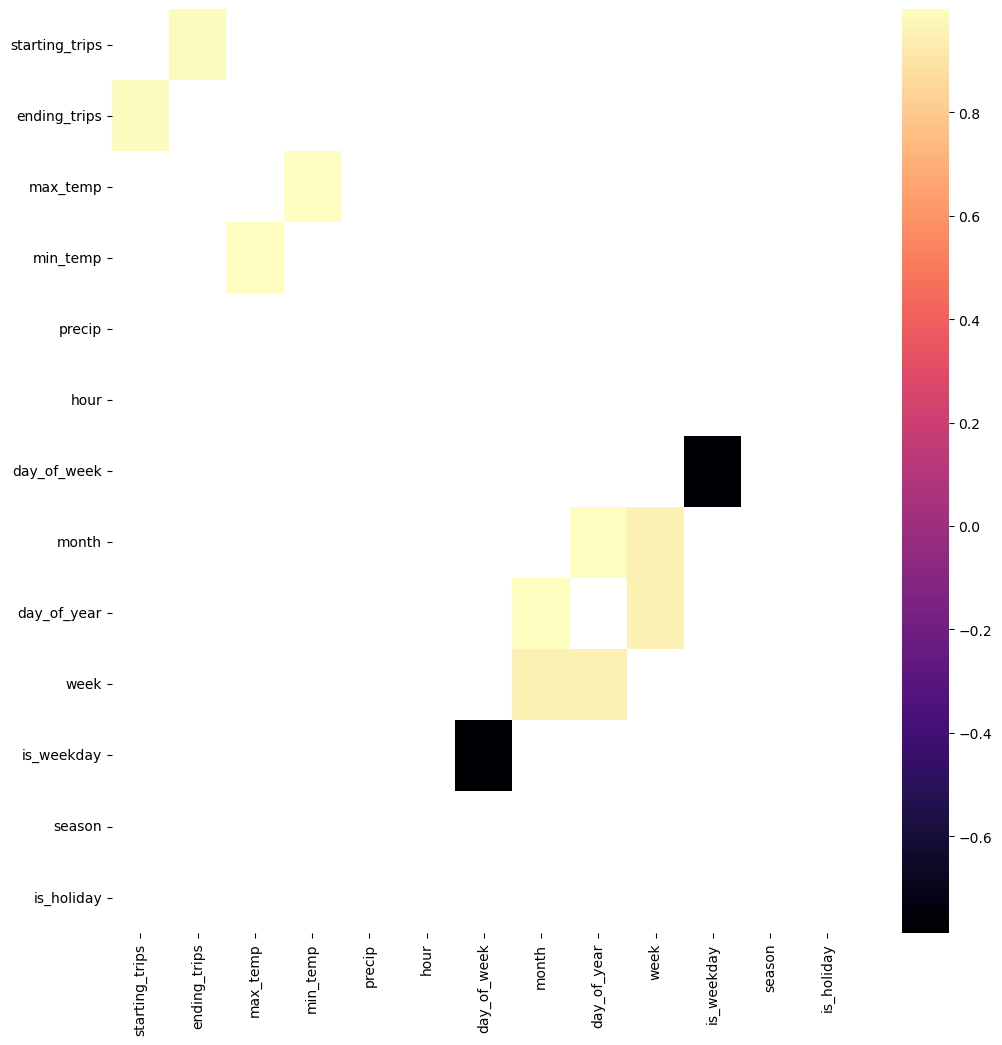

In [145]:
corr = df_bike_trips_corr.corr()

#kot = corr[((corr>=.7) or (corr<=-.7))]
kot = corr[((corr >= .7) | (corr <= -.7)) & (corr !=1.000)]
plt.figure(figsize=(12,12))
sns.heatmap(kot, cmap="magma")

In [146]:
def corrFilter(x: pd.DataFrame, bound: float):
    xCorr = x.corr()
    xFiltered = xCorr[((xCorr >= bound) | (xCorr <= -bound)) & (xCorr !=1.000)]
    xFlattened = xFiltered.unstack().sort_values().drop_duplicates()
    return xFlattened

corrFilter(df_bike_trips_corr, .7)

day_of_week     is_weekday       -0.787324
day_of_year     week              0.946291
month           week              0.946450
starting_trips  ending_trips      0.986743
month           day_of_year       0.996499
max_temp        min_temp          0.999684
starting_trips  starting_trips         NaN
dtype: float64

In [147]:
df_bike_trips_hourly.isna().sum()

starting_trips                         0
ending_trips                           0
Most Occuring Starting Neighborhood    0
max_temp                               0
min_temp                               0
precip                                 0
hour                                   0
day_of_week                            0
month                                  0
day_of_year                            0
week                                   0
is_weekday                             0
date                                   0
season                                 0
is_holiday                             0
dtype: int64

For starting trips the correlation can be ignored, as the correlation with itself is 1 and as there are no null values in our dataset. 

# Drop features

Looking at the *Correlation* seven pairs have high correlation. So either one of them can be dropped. The features that we will drop are: day_of_week, max_temp. For three pairs we see different correlation "relationships": day_of_year, as well as month correlate highly to week and month also correlates highly to day_of_year. So the one feature that we will keep is the month, as we also looked at it in our descriptive analytics. The starting_trips can be ignored in this case, as the correlation with the variable itself is always 1. We also drop 'date', because it's equivalent to day_of_year and it is already represented by the index.

In [148]:
columns_to_drop = ['max_temp', 'day_of_week', 'day_of_year', 'week', 'date']
df_bike_trips_hourly.drop(columns_to_drop, axis=1, inplace=True)
df_bike_trips_hourly.head()

,starting_trips,ending_trips,Most Occuring Starting Neighborhood,min_temp,precip,hour,month,is_weekday,season,is_holiday
index,,,,,,,,,,
2016-01-01 00:00:00,26.0,17.0,Old City,6.7,0.0,0,1,1,4,1
2016-01-01 01:00:00,39.0,32.0,Washington Square West,7.2,0.0,1,1,1,4,1
2016-01-01 02:00:00,33.0,37.0,"Kensington, Old",6.7,0.0,2,1,1,4,1
2016-01-01 03:00:00,6.0,10.0,Rittenhouse,6.7,0.0,3,1,1,4,1
2016-01-01 04:00:00,1.0,1.0,"Kensington, West",6.1,0.0,4,1,1,4,1


In [149]:
df_bike_trips_hourly.to_parquet('../../data/bike_trips_hourly.parquet')

# Lasso regression

In [150]:
input_features = df_bike_trips_hourly.drop(columns=["starting_trips"])
predicted_variable = df_bike_trips_hourly["starting_trips"]

In [151]:
# scale input features
scaler = StandardScaler()
input_features_scaled = scaler.fit_transform(input_features.values)

ValueError: could not convert string to float: 'Old City'

In [152]:
input_features.head()

,ending_trips,Most Occuring Starting Neighborhood,min_temp,precip,hour,month,is_weekday,season,is_holiday
index,,,,,,,,,
2016-01-01 00:00:00,17.0,Old City,6.7,0.0,0,1,1,4,1
2016-01-01 01:00:00,32.0,Washington Square West,7.2,0.0,1,1,1,4,1
2016-01-01 02:00:00,37.0,"Kensington, Old",6.7,0.0,2,1,1,4,1
2016-01-01 03:00:00,10.0,Rittenhouse,6.7,0.0,3,1,1,4,1
2016-01-01 04:00:00,1.0,"Kensington, West",6.1,0.0,4,1,1,4,1


In [35]:
# fit data to the linear regression model
model = Lasso(alpha=1)
model.fit(input_features_scaled, predicted_variable)
print("Coefficients ", model.coef_)


Coefficients  [72.33166417 -0.          0.         -0.2796798   0.          0.
 -0.         -0.        ]


## Lasso with optimal alpha

### K-fold cross validation

In [36]:
# Lasso with 5 fold cross-validation
model = LassoCV(cv=5, random_state=0, max_iter=10000)

# Fit model
model.fit(input_features_scaled, predicted_variable)

LassoCV(cv=5, max_iter=10000, random_state=0)

In [37]:
model.alpha_

0.2236327309467648

### Best model

In [38]:
# Set best alpha
lasso_best = Lasso(alpha=model.alpha_)
lasso_best.fit(input_features_scaled, predicted_variable)

Lasso(alpha=0.2236327309467648)

In [39]:
print(list(zip(lasso_best.coef_, input_features)))

[(73.78715502068071, 'ending_trips'), (-0.6466065985568269, 'min_temp'), (0.023341455299180143, 'precip'), (-1.49291912631368, 'hour'), (0.0, 'month'), (0.0, 'is_weekday'), (-0.08328966368648401, 'season'), (-0.0, 'is_holiday')]


### Model evaluation

In [40]:
print('R squared training set', round(lasso_best.score(input_features_scaled, predicted_variable)*100, 2))
print('R squared test set', round(lasso_best.score(input_features_scaled, predicted_variable)*100, 2))


R squared training set 97.45
R squared test set 97.45


In [41]:
mean_squared_error(predicted_variable, lasso_best.predict(input_features_scaled))

140.58296858093482

## Lasso regression with best alpha

In [42]:
input_features.head()

,ending_trips,min_temp,precip,hour,month,is_weekday,season,is_holiday
index,,,,,,,,
2016-01-01 00:00:00,17.0,6.7,0.0,0,1,1,4,1
2016-01-01 01:00:00,32.0,7.2,0.0,1,1,1,4,1
2016-01-01 02:00:00,37.0,6.7,0.0,2,1,1,4,1
2016-01-01 03:00:00,10.0,6.7,0.0,3,1,1,4,1
2016-01-01 04:00:00,1.0,6.1,0.0,4,1,1,4,1


In [43]:
model = Lasso(alpha=0.2236327309467648)
model.fit(input_features_scaled, predicted_variable)
print("Coefficients ", model.coef_)


Coefficients  [ 7.37871550e+01 -6.46606599e-01  2.33414553e-02 -1.49291913e+00
  0.00000000e+00  0.00000000e+00 -8.32896637e-02 -0.00000000e+00]


# TODO: Begründung warum wir min_temp o.ä trotzdem im model behalten wollen und nicht droppen? 
# TODO: WEITER FEATURES FINDEN, 2 SIND ZU MAGER?
In general, it is a good idea to consider dropping features that are identified as unimportant by both lasso regression and feature correlation. However, you should also consider the context of your problem and the goals of your model. It is possible that some features that are identified as unimportant by these techniques may still be useful for your model, or that removing them may have unintended consequences. Therefore, it is important to carefully evaluate the impact of removing features on the performance of your model before making a final decision.

VIELLEICHT KANN DIESE BEGRÜNDUNG UNS HELFEN?

In [44]:
# trips_hourly_df = trips_hourly_df.drop(columns={"precip", "day_of_week"})
df_bike_trips_hourly.to_parquet('../../data/bike_trips_hourly_FINAL.parquet')